# Importing Data and Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error  
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# importing train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# EDA

In [ ]:
train.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [ ]:
train.shape

(300, 6)

In [ ]:
train.describe()

,id,Open,Close,Volume
count,300.000000,300.000000,300.000000,3.000000e+02
mean,149.500000,75.977813,79.430489,1.866300e+08
std,86.746758,16.158343,13.878395,7.952792e+07
min,0.000000,40.269435,47.979353,5.991330e+07
25%,74.750000,64.872395,69.689227,1.324862e+08
50%,149.500000,79.805683,82.991900,1.715536e+08
75%,224.250000,88.342927,89.719145,2.201842e+08
max,299.000000,102.558322,103.119373,6.935702e+08


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Date      300 non-null    object 
 2   Open      300 non-null    float64
 3   Close     300 non-null    float64
 4   Volume    300 non-null    int64  
 5   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.2+ KB


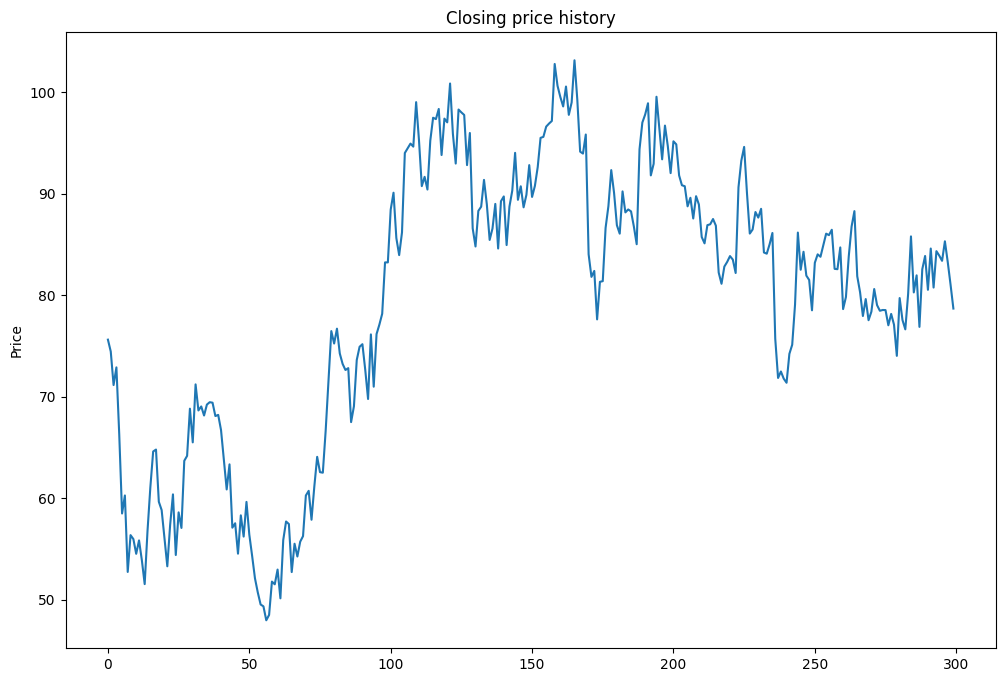

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train['Close'])
plt.title('Closing price history')
plt.ylabel('Price')
plt.show()

In [ ]:
train.isnull().sum()

id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_53136\514670500.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col])
C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_53136\514670500.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col])
C:\Users\Aaryan Shetty\AppData\L

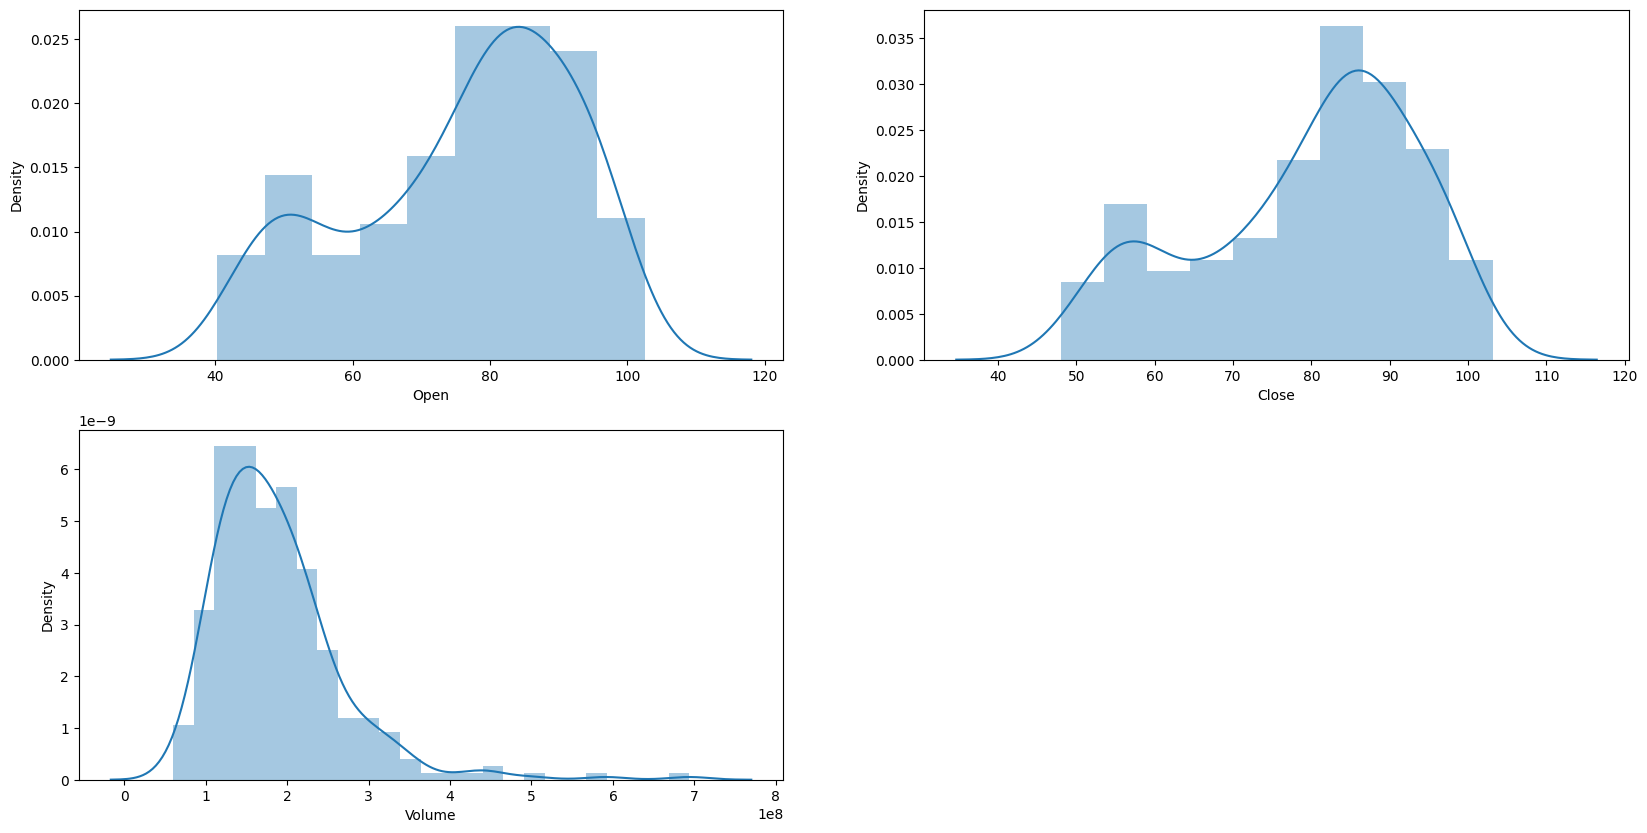

In [ ]:
features = train[['Open', 'Close', 'Volume']]

plt.figure(figsize=(20, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[col])

plt.show()

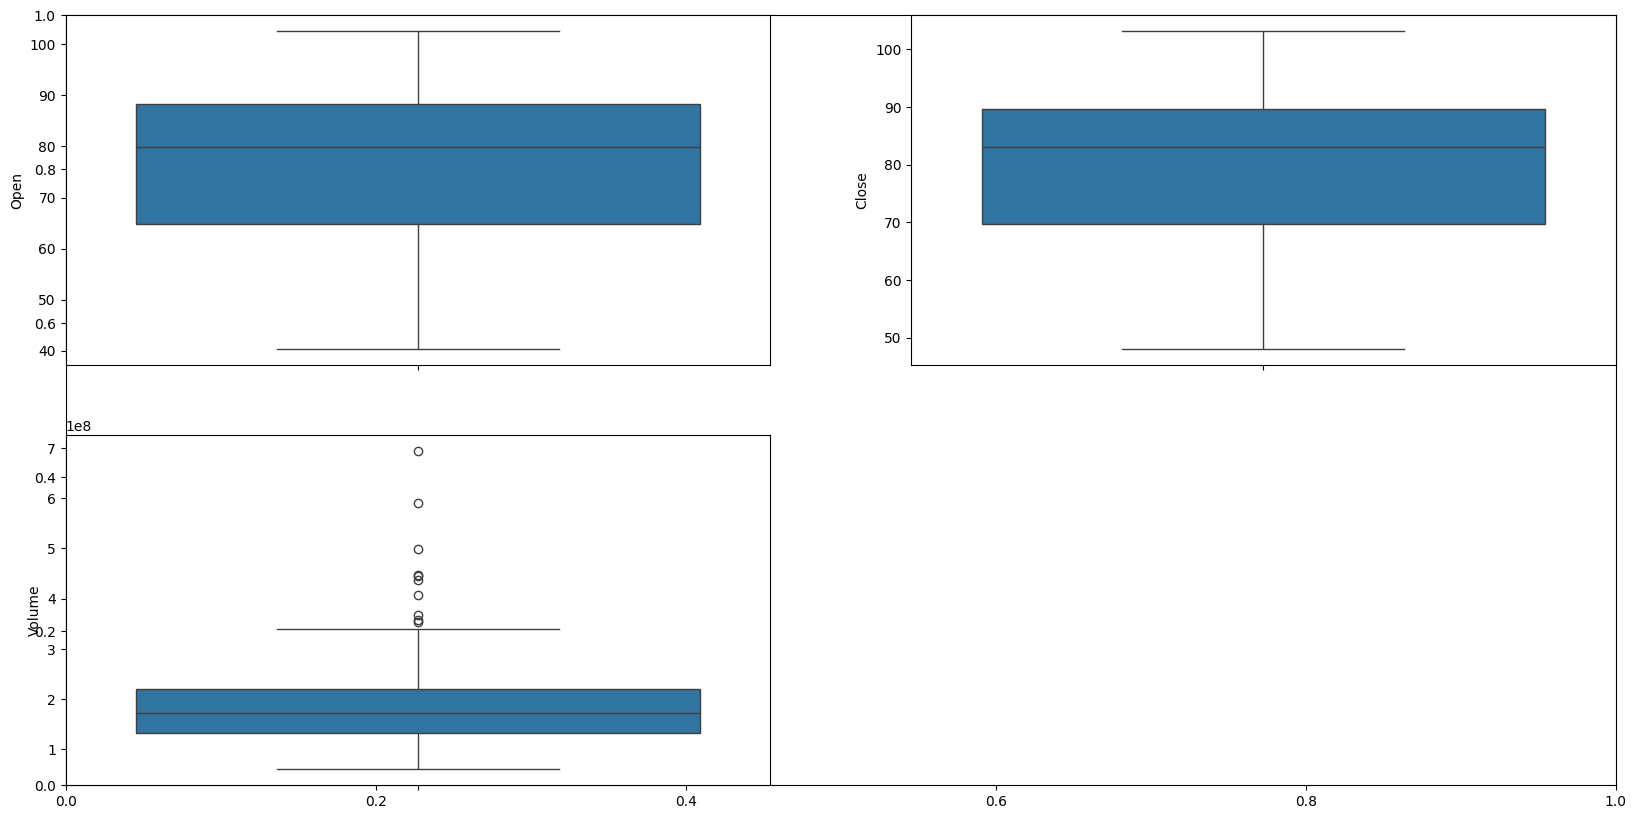

In [ ]:
plt.subplots(figsize=(20, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(train[col])

plt.show()

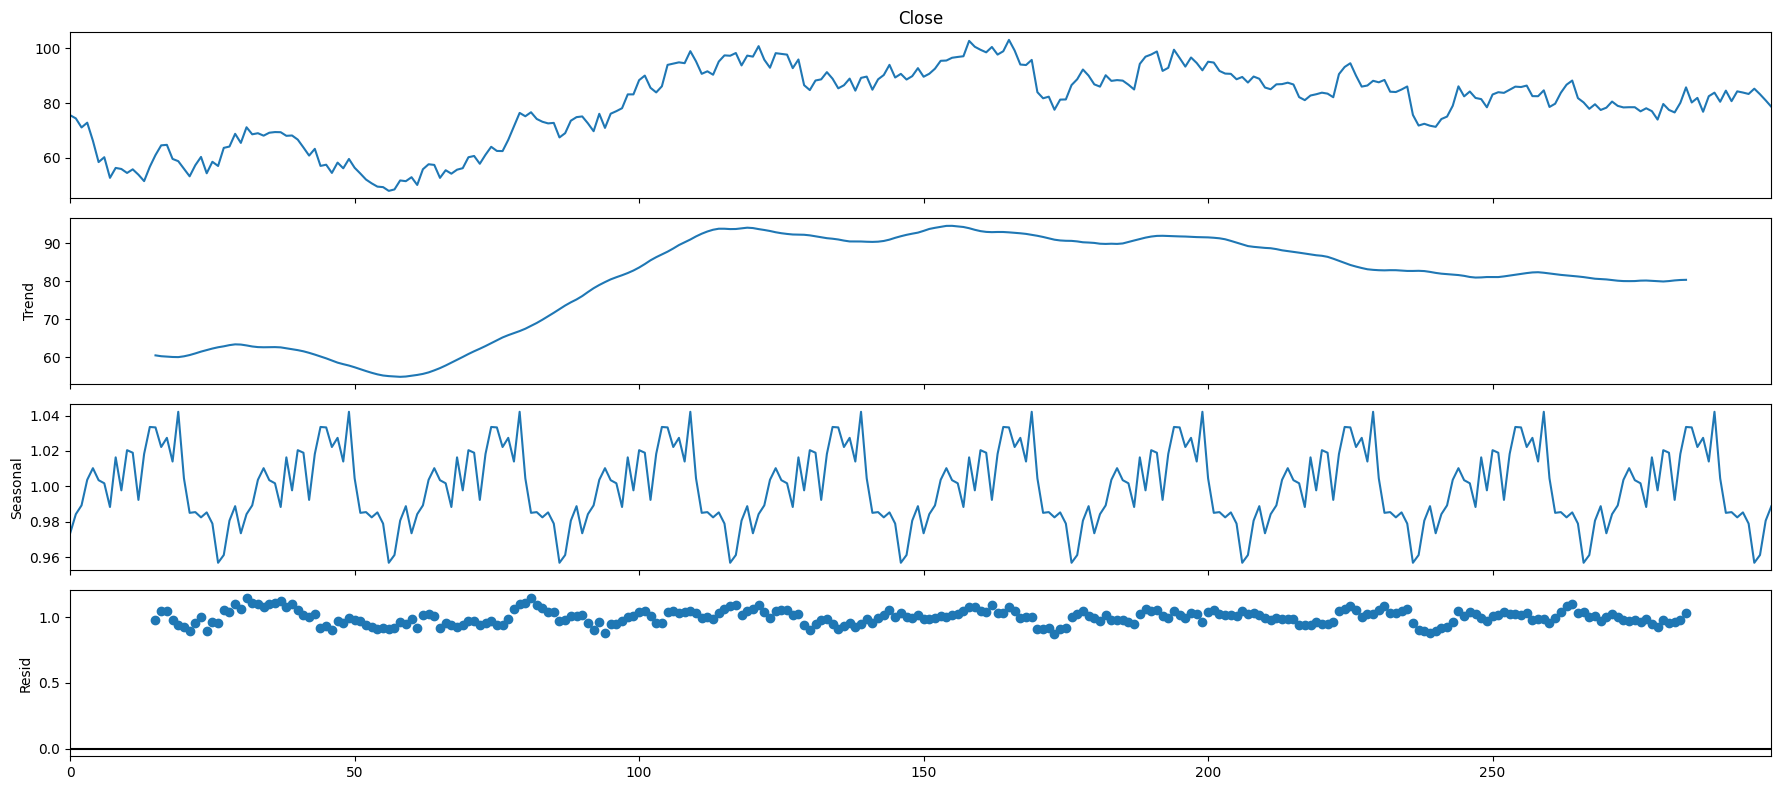

In [ ]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(train['Close'], model='multiplicative', period=30)
fig = decomposition.plot()
plt.show()